## Toy example for using spatially adjusted Louvain Community Detection

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from expert_louvain import *

## Simulating a spatially embedded network with spatial group structure injected

In [2]:
np.random.seed(42)

# parameters to play around with
n = 1000 # number of nodes in the network
mass_min = 1 # minimum mass of a node
mass_max = 7 # maximum mass of a node
minus_alpha = 2 # gravity parameter
dastance_scalar = 5 # gravity parameter
spatial_amplifier = 2 # the factor by which we amplify edge weights during simulation
min_weight = 1 # only weights larger than this number will be added to the network
chess_scale = 5 # chessboard scale

# constructing a network
positions = np.random.rand(n, 2)
masses = np.random.uniform(mass_min, mass_max, size=n)
G = nx.Graph()
for i in range(n):
    G.add_node(i)

# simulating edge weights with a gravity model
weight_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(i + 1, n):
        dist = np.linalg.norm(positions[i] - positions[j]) + 1e-4
        weight = (masses[i] * masses[j]) / ((dist * dastance_scalar + 1) ** (minus_alpha)) 
        weight_matrix[i, j] = weight_matrix[j, i] = weight

# creating a function that amplify edge weights if nodes are on the same chessboard color
def get_chessboard_color(pos):
    grid_x = int(pos[0] * chess_scale)
    grid_y = int(pos[1] * chess_scale)
    return (grid_x + grid_y) % 2  # alternating pattern

# amplifying certain weights and adding weights to the network
for i in range(n):
    for j in range(i + 1, n):
        weight = weight_matrix[i, j]
        if get_chessboard_color(positions[i]) == get_chessboard_color(positions[j]):
            weight *= spatial_amplifier
        if weight > min_weight:
            G.add_edge(i, j, weight=weight)


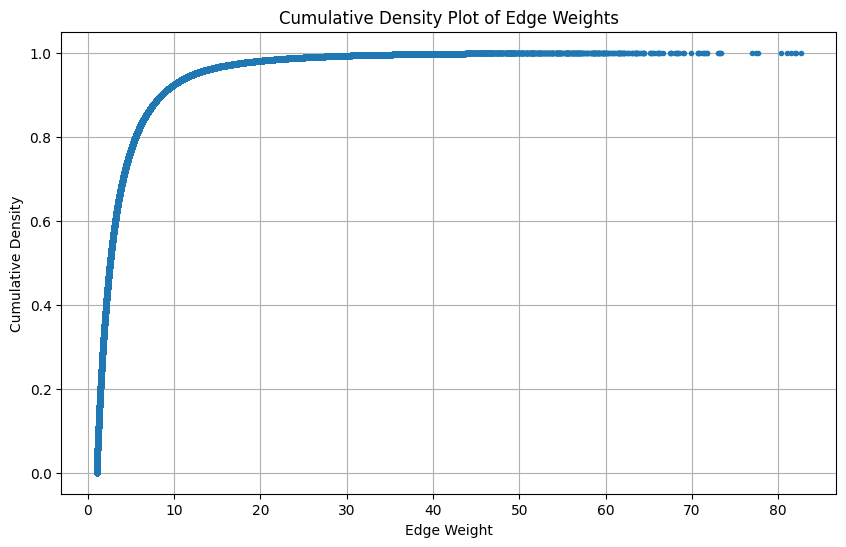

In [3]:
# plotting cumulative density distribution of edge weights

weights = [data.get('weight', 1.0) for u, v, data in G.edges(data=True)]
sorted_weights = np.sort(weights)
cdf = np.arange(1, len(sorted_weights) + 1) / len(sorted_weights)

plt.figure(figsize=(10, 6))
plt.plot(sorted_weights, cdf, marker='.', linestyle='none')
plt.xlabel("Edge Weight")
plt.ylabel("Cumulative Density")
plt.title("Cumulative Density Plot of Edge Weights")
plt.grid(True)
plt.show()


## Constructing the matrix of spatially expected edge weights based on node masses and distance bins

In [4]:
'''
Spatially adjusted community detection uses spatially expected edge weights during modularity computation.
Spatially expected edge weights result from empical distribution of weights for certain node masses within a distance bin.
Distance bin creation may be approached various ways (equally distributing dodes within bins / using a certain bin width / using a certain number of bins / etc.).
Therefore, the distance bin creation and the spatially expected weights are constructed outside of the package and is given as a single argument for the community detection algorithm.
In this example, a certain number of distance bins is used which are equally wide, covering distances from 0 to maximum distance.
'''
k = 25  # number of distance bins which is used to determine empirical expected edge weight for certain node pairs (masses and distance bin is used)

distances = np.zeros((n, n))
mass_products = np.zeros((n, n))
for i in range(n):
    for j in range(i + 1, n):
        dist = np.linalg.norm(positions[i] - positions[j])
        distances[i, j] = distances[j, i] = dist
        mass_products[i, j] = mass_products[j, i] = masses[i] * masses[j]

max_dist = np.max(distances)
bins = np.linspace(0, max_dist, k + 1)  # k bins so k+1 cutpoints

bin_weights = np.zeros(k)
bin_mass_products = np.zeros(k)
edge_bin_assignment = dict()

# edge assignment to bins
for i, j, data in G.edges(data=True):
    dist = distances[i, j]
    bin_idx = np.searchsorted(bins, dist, side='right') - 1
    bin_idx = min(bin_idx, k - 1)
    weight = data['weight']
    mass_prod = mass_products[i, j]
    
    bin_weights[bin_idx] += weight
    bin_mass_products[bin_idx] += mass_prod
    edge_bin_assignment[(i, j)] = bin_idx

# deterrence matrix or spatially expected edge weight matrix construction based on mass product matrix, edge weight matrix and distance bin assignment
deterrence_values = np.zeros(k)
for idx in range(k):
    if bin_mass_products[idx] > 0:
        deterrence_values[idx] = bin_weights[idx] / bin_mass_products[idx]

deterrence_matrix = np.zeros((n, n))
for (i, j), bin_idx in edge_bin_assignment.items():
    det = deterrence_values[bin_idx]
    w = masses[i] * masses[j] * det
    deterrence_matrix[i, j] = deterrence_matrix[j, i] = w

# if we did things correctly, weight sum is the same as expected weight sum
total_weight = sum(data['weight'] for _, _, data in G.edges(data=True))
total_det_weight = np.sum(deterrence_matrix) / 2  # since it's symmetric
scaling_factor = total_weight / total_det_weight # should be exactly 1 if weights are not modified after creating deterrence_matrix
print(f'This value should be very close to one: {scaling_factor}')
deterrence_matrix *= scaling_factor


This value should be very close to one: 1.000000000000044


In [27]:
# running the spatially adjusted and the standard Louvain Community Detection
res = 0.5
partition_geo = community_louvain.best_partition(G, resolution=res, random_state=42, expected_matrix=deterrence_matrix)
partition_standard = community_louvain.best_partition(G, resolution=res, random_state=42)

Using spatial modularity.
Using standard modularity.


## Plotting the spatially adjusted and the standard Louvain Community Detection results on the simulated data

C:\Users\imre2\AppData\Local\Temp\ipykernel_27088\1074354778.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap1 = cm.get_cmap('tab10', num_communities)
C:\Users\imre2\AppData\Local\Temp\ipykernel_27088\1074354778.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap2 = cm.get_cmap('tab10', num_communities_std)


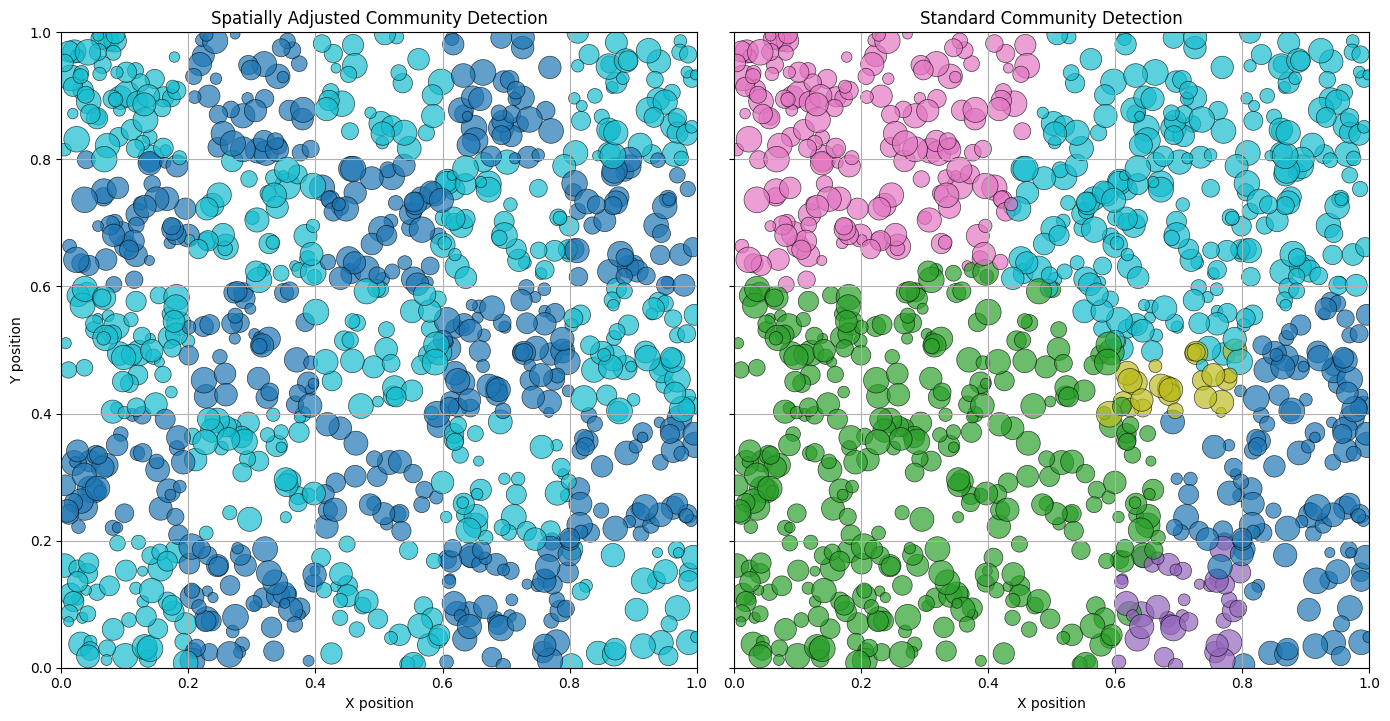

In [28]:
'''
Spatially adjusted community detection, by filtering out spatial dependence, recognize the underlying community structure and relevant nodes even if they are far away.
Standard community detection recognize some kind of spatial structure in the network but fails to treat spatial dependence. This way, the standard algorithm prefers nodes
based on modularity built on absolute edge weight, creating more local clusters.
'''

# creating colormap based on the the number of partitions
num_communities = max(partition_geo.values()) + 1
num_communities_std = max(partition_standard.values()) + 1
cmap1 = cm.get_cmap('tab10', num_communities)
cmap2 = cm.get_cmap('tab10', num_communities_std)

colors1 = [cmap1(partition_geo[i]) for i in range(n)]
colors2 = [cmap2(partition_standard[i]) for i in range(n)]
sizes = [masses[i] * 50 for i in range(n)]  # Adjust scale if needed

# node positions
x = positions[:, 0]
y = positions[:, 1]

# plot
fig, axes = plt.subplots(1, 2, figsize=(14, 8), sharex=True, sharey=True)

# left plot: spatially adjusted community detection
axes[0].scatter(x, y, s=sizes, c=colors1, alpha=0.7, edgecolors='k', linewidths=0.5)
axes[0].set_title("Spatially Adjusted Community Detection")
axes[0].set_xlabel("X position")
axes[0].set_ylabel("Y position")
axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 1)
axes[0].grid(True)
axes[0].set_aspect('equal')

# right plot: standard community detection
axes[1].scatter(x, y, s=sizes, c=colors2, alpha=0.7, edgecolors='k', linewidths=0.5)
axes[1].set_title("Standard Community Detection")
axes[1].set_xlabel("X position")
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)
axes[1].grid(True)
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()
